In [1]:
##Patient Leading Edge Analysis (gene-comorbid pair)##
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import splrep, splev

#define the file paths
base_path = "/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA_fast/output/filtered_gene_comorbids/comorbidthreshold0/first400/all_chrom/" #change based on which patients/chrom we are using
values_file = os.path.expanduser(base_path + "filtered_values_dataframe.csv")
binary_attribute_file = os.path.expanduser(base_path + "filtered_binary_attributes_dataframe.csv")
area_results_file = os.path.expanduser("/scratch/Shares/dowell/temp/ChrisO/PSEA/AREA_fast/output/AREA_output/all_chrom_comorbidthreshold0/area_scores_20250808-192325.adjpval.csv")  # Update with AREA rsults we want to look at

#import the value file, binary attribute file
count_matrix = pd.read_csv(values_file, index_col=0)
comorbid_matrix = pd.read_csv(binary_attribute_file, index_col=0)

# print(count_matrix)

# print(comorbid_matrix)

#create the merged_data
#reset index to make Patient a column for merging
count_df = count_matrix.reset_index()
comorbid_df = comorbid_matrix.reset_index()
#Merge
merged_data = pd.merge(count_df, comorbid_df, on='Patient')
# print(merged_data)

#get AREA results
area_results = pd.read_csv(area_results_file)
# print(area_results)

#define the area core function
def area_score_norm(ar_ticks, verbose=False):
    '''Calculate the GSEA like enrichment score using the comorbidity
    occurrence in the rank as our set'''
    
    ar_score = np.array([1 if i > 0 else 0 for i in ar_ticks])
    total = float(np.sum(ar_score))
    
    if total == 0:  # Handle case where no patients have comorbidity
        return [0, np.zeros(len(ar_score)), np.zeros(len(ar_score)), np.zeros(len(ar_score))]
    
    binwidth = 1.0 / float(len(ar_score))
    normalized_ar_score = np.multiply(np.divide(ar_score, total), binwidth)
    
    cumscore = np.cumsum(normalized_ar_score)
    trend = np.append(np.arange(0, 1, 1.0 / float(len(cumscore) - 1)), 1.0)
    trend = np.multiply(trend, binwidth)
    
    actual_es = (np.trapz(cumscore) - np.trapz(trend)) * 2
    
    if verbose:
        print("Binwidth                        :" + str(binwidth))
        print("Sum of normalized binary scores :" + str(np.sum(normalized_ar_score)))
        print("Sum cumulative score            :" + str(np.sum(cumscore)))
        print("Sum of trend                    :" + str(np.sum(trend)))
        print("Len of trend                    :" + str(len(trend)))
        print("Actual Area                     :" + str(actual_es))
    
    return [actual_es, normalized_ar_score, trend, cumscore]

#define the leading edge analysis function
def run_patient_leading_edge_analysis(gene_id, comorbidity_name, merged_data, verbose=True):
    '''
    Run patient leading edge analysis for a specific gene-comorbidity pair
    using AREA algorithm
    '''
    
    print(f"PATIENT LEADING EDGE ANALYSIS")
    print(f"=" * 60)
    print(f"Gene: {gene_id}")
    print(f"Comorbidity: {comorbidity_name}")
    
    #Prepare data
    if gene_id not in merged_data.columns:
        print(f"Error: Gene {gene_id} not found in expression data")
        return None
    
    if comorbidity_name not in merged_data.columns:
        print(f"Error: Comorbidity {comorbidity_name} not found in data")
        return None
    
    #create working dataframe
    df = merged_data[['Patient', gene_id, comorbidity_name]].copy()
    
    #Sort patients by gene expression
    df_sorted = df.sort_values(gene_id, ascending=False).reset_index(drop=True)  # Sort HIGH to LOW expression
    
    #create binary comorbidity array in the sorted order
    thiscomorbidity_binary = df_sorted[comorbidity_name].tolist()
    
    print(f"\nData prepared:")
    print(f"Total patients: {len(df_sorted)}")
    print(f"Patients with comorbidity: {sum(thiscomorbidity_binary)}")
    print(f"Expression range: {df_sorted[gene_id].min():.3f} - {df_sorted[gene_id].max():.3f}")
    
    #calculate enrichment score using AREA
    actual_es, normalized_ar_score, trend, cumscore = area_score_norm(thiscomorbidity_binary, verbose=verbose)
    
    print(f"\nEnrichment Results:")
    print(f"AREA Enrichment Score: {actual_es:.6f}")
    
    #find peak enrichment position (leading edge)
    #the cumulative score represents the running enrichment at each patient position
    trend_aligned = trend[:len(cumscore)]  # Trim trend to match cumscore length
    running_enrichment = cumscore - trend_aligned  # Difference from null expectation
    max_enrichment_pos = np.argmax(np.abs(running_enrichment))
    max_enrichment_score = running_enrichment[max_enrichment_pos]
    
    print(f"Peak enrichment position: {max_enrichment_pos + 1} (of {len(df_sorted)})")
    print(f"Peak enrichment score: {max_enrichment_score:.6f}")
    
    #identify leading edge patients
    if actual_es > 0:
        # Positive enrichment - comorbid patients enriched at HIGH expression
        leading_edge_positions = list(range(max_enrichment_pos + 1))
    else:
        # Negative enrichment - comorbid patients enriched at LOW expression  
        leading_edge_positions = list(range(max_enrichment_pos, len(df_sorted)))
    
    # Get the leading edge patients
    leading_edge_all = df_sorted.iloc[leading_edge_positions].copy()
    leading_edge_with_comorbid = leading_edge_all[leading_edge_all[comorbidity_name] == 1].copy()
    leading_edge_without_comorbid = leading_edge_all[leading_edge_all[comorbidity_name] == 0].copy()
    
    # Add position information
    leading_edge_all['expression_rank'] = [pos + 1 for pos in leading_edge_positions]
    leading_edge_with_comorbid['expression_rank'] = leading_edge_with_comorbid.index + 1
    leading_edge_without_comorbid['expression_rank'] = leading_edge_without_comorbid.index + 1
    
    print(f"\nLeading Edge Results:")
    print(f"Leading edge size (all patients): {len(leading_edge_all)}")
    print(f"Leading edge patients with comorbidity: {len(leading_edge_with_comorbid)}")
    print(f"Leading edge patients WITHOUT comorbidity: {len(leading_edge_without_comorbid)}")
    print(f"Percentage of comorbid patients in leading edge: {len(leading_edge_with_comorbid)/sum(thiscomorbidity_binary)*100:.1f}%")
    
    #non-comorbid patients in leading edge
    total_non_comorbid = len(df_sorted) - sum(thiscomorbidity_binary)
    if total_non_comorbid > 0:
        print(f"Percentage of non-comorbid patients in leading edge: {len(leading_edge_without_comorbid)/total_non_comorbid*100:.1f}%")
    
    # Step 7: Return comprehensive results
    results = {
        'gene': gene_id,
        'comorbidity': comorbidity_name,
        'area_enrichment_score': actual_es,
        'peak_position': max_enrichment_pos + 1,
        'peak_enrichment_score': max_enrichment_score,
        'leading_edge_all_patients': leading_edge_all,
        'leading_edge_comorbid_patients': leading_edge_with_comorbid,
        'leading_edge_non_comorbid_patients': leading_edge_without_comorbid,
        'sorted_patients': df_sorted,
        'running_enrichment': running_enrichment,
        'cumscore': cumscore,
        'trend': trend,
        'normalized_ar_score': normalized_ar_score,
        'comorbidity_binary': thiscomorbidity_binary
    }
    
    return results

In [2]:
#set gene and comorbid perameter
example_gene = 'ENSG00000129219' #NLGN3 = ENSG00000196338, RUNX2=ENSG00000124813, RCAN1 = ENSG00000159200, DONSON = ENSG00000159147, SIK1b = ENSG00000275993, COMP = ENSG00000105664, nlgn3 = ENSMUSG00000031302
#NB - Depression and ADHD ; ENSG00000160191.17 (PDE9A)
# NB - vitamin_D_deficiency ; ENSG00000019186
example_comorbidity = 'anxiety' #obstructive_sleep_apnea_syndrome

#quick verification they are in the merged datafarame
print(f"Gene {example_gene} in data: {example_gene in merged_data.columns}")
print(f"Comorbidity {example_comorbidity} in data: {example_comorbidity in merged_data.columns}")


# for i in merged_data.columns.to_list():
#     if i[:1]!='E':
#         print(i)


Gene ENSG00000129219 in data: True
Comorbidity anxiety in data: True


In [3]:
#run it
patient_results = run_patient_leading_edge_analysis(
    gene_id=example_gene,
    comorbidity_name=example_comorbidity, 
    merged_data=merged_data,
    verbose=True
)

PATIENT LEADING EDGE ANALYSIS
Gene: ENSG00000129219
Comorbidity: anxiety

Data prepared:
Total patients: 400
Patients with comorbidity: 53
Expression range: 241.748 - 1203.926
Binwidth                        :0.0025
Sum of normalized binary scores :0.0024999999999999996
Sum cumulative score            :0.656037735849056
Sum of trend                    :0.5
Len of trend                    :400
Actual Area                     :0.312075471698112

Enrichment Results:
AREA Enrichment Score: 0.312075
Peak enrichment position: 275 (of 400)
Peak enrichment score: 0.000642

Leading Edge Results:
Leading edge size (all patients): 275
Leading edge patients with comorbidity: 50
Leading edge patients WITHOUT comorbidity: 225
Percentage of comorbid patients in leading edge: 94.3%
Percentage of non-comorbid patients in leading edge: 64.8%


Creating patient enrichment visualization...


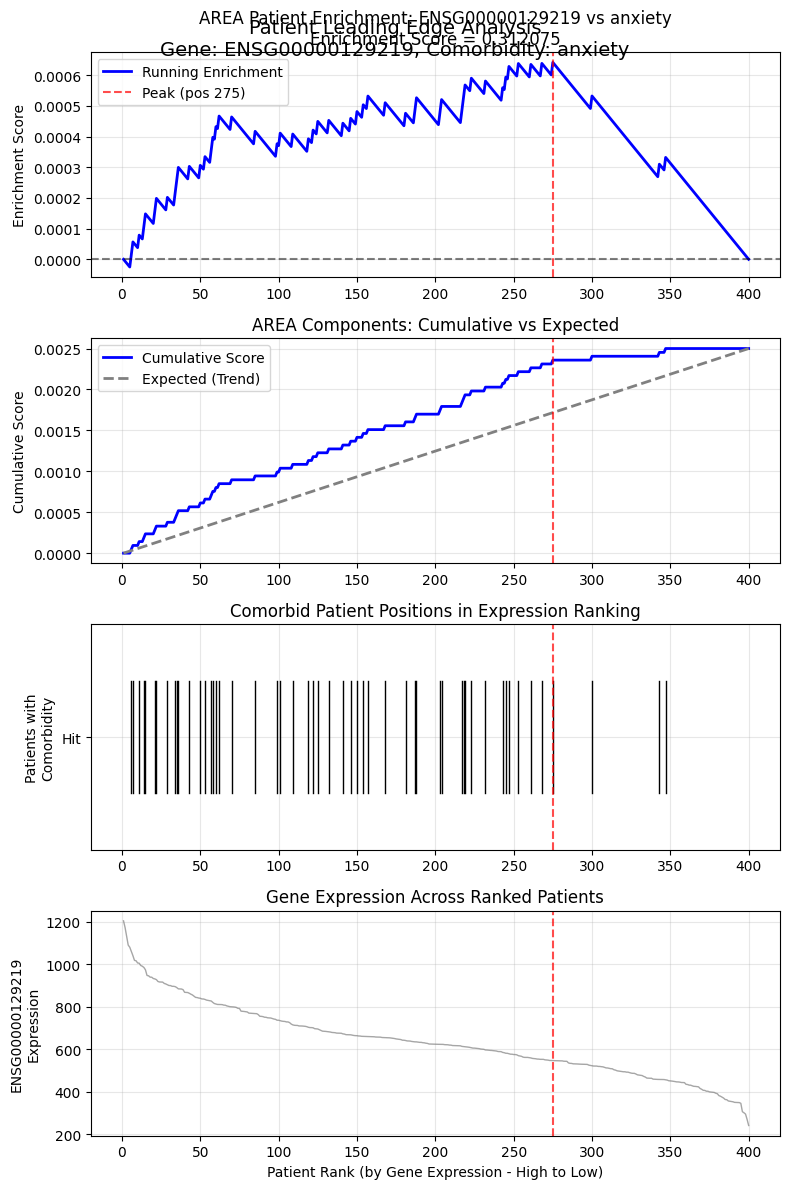


PATIENT LEADING EDGE SUMMARY
Gene analyzed: ENSG00000129219
Comorbidity: anxiety
Enrichment Score: 0.312075
Peak enrichment position: 275 (of 400)

Patient Statistics:
  Total patients: 400
  Patients with comorbidity: 53
  Patients without comorbidity: 347
  Leading edge patients (with comorbidity): 50
  Leading edge patients (without comorbidity): 225
  Leading edge fraction (comorbid): 94.3% of comorbid patients
  Leading edge fraction (non-comorbid): 64.8% of non-comorbid patients

Leading Edge Patient Characteristics:
  WITH comorbidity:
    Expression range: 546.748 - 1060.385
    Mean expression: 739.923
    Median rank: 124
  WITHOUT comorbidity:
    Expression range: 547.353 - 1203.926
    Mean expression: 713.212
    Median rank: 140
  Enrichment direction: HIGH expression (comorbid patients have higher ENSG00000129219 expression)

Clinical Interpretation:
  The leading edge includes patients with the highest ENSG00000129219 expression.
  - 50 patients WITH anxiety
  - 225 p

In [4]:
#Visualization (all claude... I will fix this later)
# Visualize Patient Leading Edge Analysis using AREA outputs
def plot_area_patient_enrichment(results, figsize=(8, 12)):
    '''Create comprehensive plot of patient-based enrichment analysis'''
    
    gene = results['gene']
    comorbidity = results['comorbidity']
    sorted_patients = results['sorted_patients']
    running_enrichment = results['running_enrichment']
    cumscore = results['cumscore']
    trend = results['trend']
    comorbidity_binary = results['comorbidity_binary']
    
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    
    patient_positions = range(1, len(sorted_patients) + 1)
    
    # Plot 1: Running Enrichment Score (cumscore - trend)
    axes[0].plot(patient_positions, running_enrichment, 'b-', linewidth=2, label='Running Enrichment')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0].axvline(x=results['peak_position'], color='red', linestyle='--', alpha=0.7, 
                   label=f'Peak (pos {results["peak_position"]})')
    axes[0].set_title(f'AREA Patient Enrichment: {gene} vs {comorbidity}\n'
                     f'Enrichment Score = {results["area_enrichment_score"]:.6f}', fontsize=12)
    axes[0].set_ylabel('Enrichment Score')
    axes[0].set_xlim(-20, 420)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative Score and Trend
    axes[1].plot(patient_positions, cumscore, 'blue', linewidth=2, label='Cumulative Score')
    axes[1].plot(patient_positions, trend[:len(cumscore)], 'gray', linewidth=2, linestyle='--', label='Expected (Trend)')
    axes[1].axvline(x=results['peak_position'], color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlim(-20, 420)
    axes[1].set_ylabel('Cumulative Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('AREA Components: Cumulative vs Expected')
    
    # Plot 3: Patient Hits (where comorbid patients appear)
    hit_positions = [i+1 for i, val in enumerate(comorbidity_binary) if val == 1]
    if len(hit_positions) > 0:
        for i in hit_positions:
            axes[2].plot([i, i], [1.25,0.75], color='k', linestyle='-', linewidth=1)
        # hit_y = [1] * len(hit_positions)
        # axes[2].scatter(hit_positions, hit_y, c='red', s=3, alpha=0.8, marker='|')
    axes[2].axvline(x=results['peak_position'], color='red', linestyle='--', alpha=0.7)
    axes[2].set_ylabel('Patients with\nComorbidity')
    axes[2].set_ylim(0.5, 1.5)
    axes[2].set_xlim(-20, 420)
    axes[2].set_yticks([1])
    axes[2].set_yticklabels(['Hit'])
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('Comorbid Patient Positions in Expression Ranking')
    
    # Plot 4: Gene Expression Distribution
    axes[3].plot(patient_positions, sorted_patients[gene], 'gray', alpha=0.7, linewidth=1)
    axes[3].axvline(x=results['peak_position'], color='red', linestyle='--', alpha=0.7)
    axes[3].set_xlim(-20, 420)
    axes[3].set_xlabel('Patient Rank (by Gene Expression - High to Low)')
    axes[3].set_ylabel(f'{gene}\nExpression')
    axes[3].set_title('Gene Expression Across Ranked Patients')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Patient Leading Edge Analysis\n'
                 f'Gene: {gene}, Comorbidity: {comorbidity}', 
                 fontsize=14, y=0.98)
    plt.savefig(f'Patient Leading Edge Analysis_Gene: {gene}, Comorbidity: {comorbidity}.png',dpi=600)
    plt.show()

def summarize_patient_results(results):
    '''Provide detailed summary of patient leading edge results'''
    
    print(f"\n" + "=" * 70)
    print("PATIENT LEADING EDGE SUMMARY")
    print("=" * 70)
    
    gene = results['gene']
    comorbidity = results['comorbidity']
    sorted_patients = results['sorted_patients']
    leading_edge_comorbid = results['leading_edge_comorbid_patients']
    leading_edge_non_comorbid = results['leading_edge_non_comorbid_patients']
    
    total_patients = len(sorted_patients)
    total_comorbid = sum(results['comorbidity_binary'])
    total_non_comorbid = total_patients - total_comorbid
    leading_edge_comorbid_size = len(leading_edge_comorbid)
    leading_edge_non_comorbid_size = len(leading_edge_non_comorbid)
    
    print(f"Gene analyzed: {gene}")
    print(f"Comorbidity: {comorbidity}")
    print(f"Enrichment Score: {results['area_enrichment_score']:.6f}")
    print(f"Peak enrichment position: {results['peak_position']} (of {total_patients})")
    print(f"")
    print(f"Patient Statistics:")
    print(f"  Total patients: {total_patients}")
    print(f"  Patients with comorbidity: {total_comorbid}")
    print(f"  Patients without comorbidity: {total_non_comorbid}")
    print(f"  Leading edge patients (with comorbidity): {leading_edge_comorbid_size}")
    print(f"  Leading edge patients (without comorbidity): {leading_edge_non_comorbid_size}")
    print(f"  Leading edge fraction (comorbid): {leading_edge_comorbid_size/total_comorbid*100:.1f}% of comorbid patients")
    if total_non_comorbid > 0:
        print(f"  Leading edge fraction (non-comorbid): {leading_edge_non_comorbid_size/total_non_comorbid*100:.1f}% of non-comorbid patients")
    
    if len(leading_edge_comorbid) > 0 or len(leading_edge_non_comorbid) > 0:
        print(f"")
        print(f"Leading Edge Patient Characteristics:")
        
        if len(leading_edge_comorbid) > 0:
            le_comorbid_expression = leading_edge_comorbid[gene]
            print(f"  WITH comorbidity:")
            print(f"    Expression range: {le_comorbid_expression.min():.3f} - {le_comorbid_expression.max():.3f}")
            print(f"    Mean expression: {le_comorbid_expression.mean():.3f}")
            print(f"    Median rank: {leading_edge_comorbid['expression_rank'].median():.0f}")
        
        if len(leading_edge_non_comorbid) > 0:
            le_non_comorbid_expression = leading_edge_non_comorbid[gene]
            print(f"  WITHOUT comorbidity:")
            print(f"    Expression range: {le_non_comorbid_expression.min():.3f} - {le_non_comorbid_expression.max():.3f}")
            print(f"    Mean expression: {le_non_comorbid_expression.mean():.3f}")
            print(f"    Median rank: {leading_edge_non_comorbid['expression_rank'].median():.0f}")
        
        # Determine enrichment direction
        if results['area_enrichment_score'] > 0:
            print(f"  Enrichment direction: HIGH expression (comorbid patients have higher {gene} expression)")
        else:
            print(f"  Enrichment direction: LOW expression (comorbid patients have lower {gene} expression)")
        
        print(f"")
        print(f"Clinical Interpretation:")
        if results['area_enrichment_score'] > 0:
            print(f"  The leading edge includes patients with the highest {gene} expression.")
            print(f"  - {leading_edge_comorbid_size} patients WITH {comorbidity}")
            print(f"  - {leading_edge_non_comorbid_size} patients WITHOUT {comorbidity}")
            print(f"")
            if leading_edge_non_comorbid_size > 0:
                print(f"  The {leading_edge_non_comorbid_size} non-comorbid patients in the leading edge are particularly interesting:")
                print(f"  They have the molecular signature (high {gene} expression) but haven't manifested {comorbidity}.")
                print(f"  These could represent:")
                print(f"    • Pre-symptomatic individuals at risk")
                print(f"    • Resilient/protected individuals")
                print(f"    • Patients with incomplete phenotyping")
        else:
            print(f"  The leading edge includes patients with the lowest {gene} expression.")
            print(f"  - {leading_edge_comorbid_size} patients WITH {comorbidity}")
            print(f"  - {leading_edge_non_comorbid_size} patients WITHOUT {comorbidity}")
            print(f"")
            if leading_edge_non_comorbid_size > 0:
                print(f"  The {leading_edge_non_comorbid_size} non-comorbid patients with low {gene} expression")
                print(f"  may represent individuals at risk for developing {comorbidity}.")

# Run visualization and summary
if 'patient_results' in locals() and patient_results is not None:
    print("Creating patient enrichment visualization...")
    plot_area_patient_enrichment(patient_results)
    summarize_patient_results(patient_results)
    
    # Save leading edge patients to CSV - both groups
    if len(patient_results['leading_edge_comorbid_patients']) > 0:
        output_filename_with = f"leading_edge_WITH_{patient_results['comorbidity']}_{patient_results['gene']}.csv"
        patient_results['leading_edge_comorbid_patients'].to_csv(output_filename_with, index=False)
        print(f"\n✓ Leading edge patients WITH comorbidity saved to: {output_filename_with}")
    
    if len(patient_results['leading_edge_non_comorbid_patients']) > 0:
        output_filename_without = f"leading_edge_WITHOUT_{patient_results['comorbidity']}_{patient_results['gene']}.csv"
        patient_results['leading_edge_non_comorbid_patients'].to_csv(output_filename_without, index=False)
        print(f"✓ Leading edge patients WITHOUT comorbidity saved to: {output_filename_without}")
    
    print(f"\n✓ Analysis complete!")
else:
    print("No patient results available.")

251


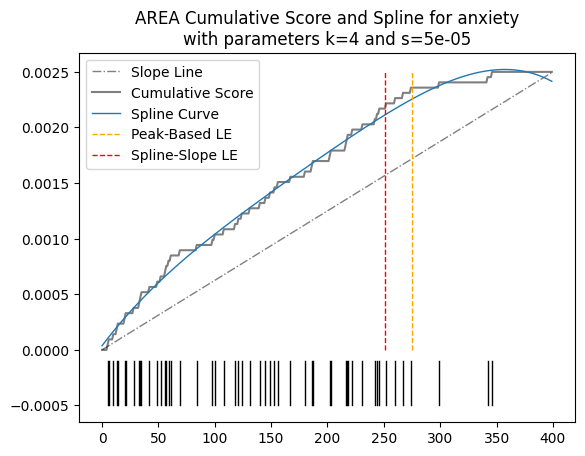

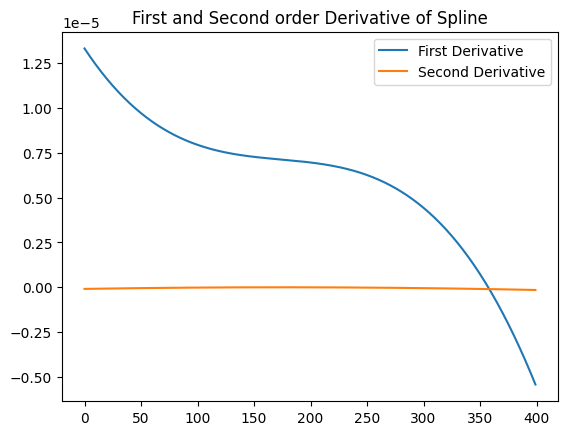

In [5]:
def get_matchback(stand_list, Enr_score=0):
    """
    Gets the first instance where the cumulative enrichment change lowers to that
    expected from background with t.
     Enr_score > 0: ACT: want min index where starts higher then goes below background (so from positive to negative) 
     Enr_score < 0: REP: want max index where starts lower than goes above background (so from neg to positive)

     Outputs:
     * matchback:
     * frac_background: Fraction of tREs at which slope is > than that of background
    """
    # change to a numpy array
    arr = np.array(stand_list)
    frac_background = np.sum(arr > 0)/len(stand_list)
    if Enr_score > 0:
        # Thinking of activator - where goes from higher to lower
        transitions = np.where((arr[:-1] > 0) & (arr[1:] <= 0))[0]
        if transitions.size == 0:
            matchback = 0
        else:
            matchback = np.min(transitions) + 1
    else:
        # Thinking of activator - where goes from lower to higher
        transitions = np.where((arr[:-1] < 0) & (arr[1:] >= 0))[0]
        if transitions.size == 0:
            matchback = 0
        else:
            matchback = np.max(transitions) + 1
    return matchback, frac_background


# print(patient_results['cumscore'])
# ########################################################################
def plot_spline(spl,x2,results,disease,params,LE_list):
    scores = results['cumscore']
    comorbidity=results['comorbidity_binary']
    y2 = splev(x2, spl)
    patients=len(scores)
    
    plt.plot([0,patients], [0, scores[-1]], color='grey', linestyle='-.', linewidth=1, label='Slope Line')
    plt.plot(x2, scores, color='black', alpha=0.5, label='Cumulative Score')
    plt.plot(x2, y2, linewidth=1, label='Spline Curve')
    plt.plot([LE_list[0], LE_list[0]], [0, scores[-1]], color='orange', linestyle='--', linewidth=1,label='Peak-Based LE')
    plt.plot([LE_list[1], LE_list[1]], [0, scores[-1]], color='red', linestyle='--', linewidth=1, label='Spline-Slope LE')
    plt.legend()
    
    for i in np.arange(len(comorbidity)):
        if comorbidity[i] == 1.0:
            plt.plot([i, i], [-0.0005,-0.0001], color='k', linestyle='-', linewidth=1)
    
    plt.title(f"AREA Cumulative Score and Spline for {disease}\nwith parameters k={params[0]} and s={params[1]}")
    plt.show()

def plot_spline_derivative(x,y1,y2):
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.legend(['First Derivative','Second Derivative'])
    plt.title('First and Second order Derivative of Spline')
    plt.show()
    
def find_spline(results):
    cumscores=results['cumscore']
    comorbidity=results['comorbidity']
    spline_k=4
    spline_s=5e-5
    Enr_score=1
    num_patients = len(cumscores)
    
    ranks = np.arange(0, num_patients, 1)
    background_slope = cumscores[-1]/num_patients # background_slope=cumscores[-1]/num_regions
    tck = splrep(ranks, cumscores, k=spline_k, s=spline_s) # get the smoothing information for the enrichment curve
    
    y_spline_prime = splev(ranks, tck, der=1) # evaluate the spline's first, second, and third derivative
    y_spline_dprime = splev(ranks, tck, der=2)
    
    stand_list = y_spline_prime - background_slope
    
    matchback, frac_back = get_matchback(stand_list, Enr_score) # calculate LE (and fraction of patients with slope above that from background)
    print(matchback)
    plot_spline(tck,ranks,results,comorbidity,[spline_k,spline_s],[patient_results['peak_position'],matchback]) #vitamin_D_deficiency
    plot_spline_derivative(ranks,y_spline_prime,y_spline_dprime)
    
    # LE_mb_list.append(matchback)
find_spline(patient_results)


In [141]:
'''
results = {
        'gene': gene_id,
        'comorbidity': comorbidity_name,
        'area_enrichment_score': actual_es,
        'peak_position': max_enrichment_pos + 1,
        'peak_enrichment_score': max_enrichment_score,
        'leading_edge_all_patients': leading_edge_all,
        'leading_edge_comorbid_patients': leading_edge_with_comorbid,
        'leading_edge_non_comorbid_patients': leading_edge_without_comorbid,
        'sorted_patients': df_sorted,
        'running_enrichment': running_enrichment,
        'cumscore': cumscore,
        'trend': trend,
        'normalized_ar_score': normalized_ar_score,
        'comorbidity_binary': comorbidity_binary
    }

patient_results = run_patient_leading_edge_analysis(
    gene_id=example_gene,
    comorbidity_name=example_comorbidity, 
    merged_data=merged_data,
    verbose=True
)'''
# print()
'''
{'anxiety', 
'ventricular_septal_defect', 
'Hashimoto_thyroiditis', 
'depressive_disorder', 
'eustachian_tube_disorder', 
'hidradenitis_suppurativa', 
'eye_disorder', 
'sensorineural_hearing_loss_disorder', 
'reactive_airway_disease', 
'Down_syndrome',
'psychiatric_disorder',
'heart_disorder', 
'sleep_apnea_syndrome', 
'strabismus', 
'attention_deficit.hyperactivity_disorder', 
'atrioventricular_septal_defect', 
'cardiac_rhythm_disease', 
'patent_foramen_ovale', 
'alopecia_areata', 
'constipation_disorder', 
'nervous_system_disorder', 
'asthma', 
'obstructive_sleep_apnea_syndrome', 
'gastroesophageal_reflux_disease', 
'complete_trisomy_21', 
'otitis_media._susceptibility_to', 
'celiac_disease', 
'congenital_heart_disease', 
'folliculitis', 
'hearing_loss_disorder', 
'atrial_septal_defect', 
'pneumonia', 
'obesity_disorder',
'hypothyroidism', 
'patent_ductus_arteriosus', 
'pulmonary_hypertension', 
'astigmatism', 
'atopic_eczema', 
'myopia', 
'respiratory_system_disorder', 
'vitamin_D_deficiency', 
'skin_disorder', 
'digestive_system_disorder', 
'conductive_hearing_loss_disorder',
'skeletal_system_disorder', 
'otorhinolaryngologic_disease'}'''

299
